# Error propagation - Cpx-only
- This notebook gives a worked example showing how to propagate uncertainty for Cpx-only thermometry for different amounts of EPMA-based error on Na$_2$O measurements.
- We use the functionality provided by Pyrolite to contour the results from Monte Carlo simulations, as well as hexplot.
- If you use the pyroplot.density command, please remember to cite Pyrolite! (Williams et al., (2020). pyrolite: Python for geochemistry. Journal of Open Source Software, 5(50), 2314, doi: 10.21105/joss.02314)
- This builds on from the notebook showing how to consider error in a single phase (Liquid_Thermometry_error_prop.ipynb). We suggest you look at that first, as its simpler when you don't have to worry about two separate phases
- We consider an example Cpx composition from Gleeson et al. (2020) - https://doi.org/10.1093/petrology/egaa094
- You can download the Excel spreadsheet here: https://github.com/PennyWieser/Thermobar/blob/main/docs/Examples/Error_propagation/Gleeson2020_Cpx_Comps.xlsx

### You need to install Thermobar once on your machine, if you haven't done this yet, uncomment the line below (remove the #)

In [1]:
#!pip install Thermobar

### You will also need to install pyrolite for this example, if you haven't done so already, uncomment the line below

In [2]:
#!pip install pyrolite

In [3]:
# Import other python stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt
import sympy as sym
pd.options.display.max_columns = None
import pyrolite

## Importing data
- Note, we haven't bothered to add the "_Cpx" names after each oxide, so we simply use "suffix="_Cpx" when we load the data

In [4]:
out=pt.import_excel('Gleeson2020_Cpx_Comps.xlsx', sheet_name="Sheet1", suffix="_Cpx")
my_input=out['my_input']
myCpxs1=out['Cpxs']

## Lets select 1 Cpx to run the calculations on
- The [[ ]] keeps it as a dataframe

In [5]:
myCpxs1.iloc[[0]]

,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx
0,51.3863,0.467,4.1961,3.8654,0.12,16.3137,21.3039,0.378,0.0007,1.0191,0


## Work out errors
- The Cameca software used to analyse these Cpxs returns the error as absolute elemental wt%, ignoring Oxygen, for each element (helpful!). These are loaded in as Na_Err, Si_Err....
- This means that you need to do some steps to work out the analytical error on each Cpx. We show these steps below.
- First, we decide it easiest to use the convert_oxide_percent_to_element_weight_percent function
to convert measured Cpx compositions as oxides into wt% to compare to these errors. Without oxygen = True, does the calculations without oxygen. You can use this function for any phase, just specify what suffix your phase has.


In [6]:
Cpx_conv=pt.convert_oxide_percent_to_element_weight_percent(df=myCpxs1, suffix='_Cpx', without_oxygen=True)
Cpx_conv.head()

,Si_wt_noO2,Mg_wt_noO2,Fe_wt_noO2,Ca_wt_noO2,Al_wt_noO2,Na_wt_noO2,K_wt_noO2,Mn_wt_noO2,Ti_wt_noO2,Cr_wt_noO2,P_wt_noO2,F_wt_noO2,H_wt_noO2,Cl_wt_noO2
0,43.155184,17.675115,5.398069,27.354400,3.989980,0.503819,0.001044,0.166972,0.502666,1.252750,0.0,0.0,0.0,0.0
1,42.432683,17.004438,5.468846,27.558497,4.967044,0.507369,0.000447,0.121440,0.625890,1.313346,0.0,0.0,0.0,0.0
2,42.399838,16.694183,5.608834,27.398388,5.209677,0.523472,0.022141,0.141541,0.681296,1.320631,0.0,0.0,0.0,0.0
3,42.649103,17.224819,5.638033,27.496627,4.631102,0.538772,0.004336,0.097927,0.632681,1.086601,0.0,0.0,0.0,0.0
4,41.057438,15.479289,7.324030,26.604851,6.874709,0.702197,0.025343,0.188588,1.005908,0.737648,0.0,0.0,0.0,0.0


- Now we calculate the % error for each element. For example, for Na, we take the Cameca error (column Na_Err),
and compare it to the concentration we just calculated in wt% for Na (column Na_wt_noO2 in the Cpx_conv dataframe)

In [7]:
Perc_Err_Na=100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2']
Perc_Err_Na.head()

0    8.534819
1    8.553938
2    8.520041
3    8.315210
4    7.049307
dtype: float64

In [8]:
# We now need to re-arrange these into a form that we can load into the function. 
# We make a new dataframe of these errors
df_Cpx_Err=pd.DataFrame(data={'SiO2_Cpx_Err': 100*my_input['Si_Err']/Cpx_conv['Si_wt_noO2'],
                            'TiO2_Cpx_Err':100*my_input['Ti_Err']/Cpx_conv['Ti_wt_noO2'],
                             'Al2O3_Cpx_Err':100*my_input['Al_Err']/Cpx_conv['Al_wt_noO2'],
                             'FeOt_Cpx_Err':100*my_input['Fe_Err']/Cpx_conv['Fe_wt_noO2'],
                            'MnO_Cpx_Err':100*my_input['Mn_Err']/Cpx_conv['Mn_wt_noO2'],
                            'MgO_Cpx_Err':100*my_input['Mg_Err']/Cpx_conv['Mg_wt_noO2'],
                            'CaO_Cpx_Err':100*my_input['Ca_Err']/Cpx_conv['Ca_wt_noO2'],
                            'Na2O_Cpx_Err':100*my_input['Na_Err']/Cpx_conv['Na_wt_noO2'],
                            'Cr2O3_Cpx_Err':100*my_input['Cr_Err']/Cpx_conv['Cr_wt_noO2'],
                               'K2O_Cpx_Err': 100*my_input['K_Err']/Cpx_conv['K_wt_noO2']}, index=[0])

## Lets select 1 Cpx, and its corresponding error as an example
- using [[ ]] keeps it as a dataframe, we reset the index because sometimes this can cause python mayhem. 

In [9]:
Cpx_1=myCpxs1.iloc[[0]].reset_index(drop=True)
Cpx_1_Err=df_Cpx_Err.iloc[[0]].reset_index(drop=True)
Cpx_1_Err

,SiO2_Cpx_Err,TiO2_Cpx_Err,Al2O3_Cpx_Err,FeOt_Cpx_Err,MnO_Cpx_Err,MgO_Cpx_Err,CaO_Cpx_Err,Na2O_Cpx_Err,Cr2O3_Cpx_Err,K2O_Cpx_Err
0,1.186416,2.148544,0.907273,3.056648,27.309951,1.129271,0.858363,8.534819,5.172622,1934.77739


## Lets calculate the errors for this Cpx
- You could do this for all Cpxs, rather than just this 1 sample, but it'll take longer, so we do a cut down version
here!
- 20,000 iterations may seem like a lot, but it really helps with the contouring

In [10]:
Calc_Cpx_dist=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err,
                                            phase_err_type="Perc", duplicates=20000, err_dist="normal")

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets calculate pressures and temperatures using a wide variety of equations for Cpx-only thermobarometry
- This cell takes  abit of time, its 20,000 calculations using a wide variety of P and T equations!

In [11]:
Calc_PT=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist)
Calc_PT.head()

,P_Wang21_eq1,T_Wang21_eq2,T_Jorgenson22,P_Jorgenson22,T_Petrelli20,T_Put_Teq32d_Peq32a,T_Put_Teq32d_Peq32b,P_Petrelli20,P_Put_Teq32d_Peq32a,P_Put_Teq32d_Peq32b,"Jd_from 0=Na, 1=Al",SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,Cr2O3_Cpx,Sample_ID_Cpx_Num,Sample_ID_Cpx,Si_Cpx_cat_6ox,Mg_Cpx_cat_6ox,Fet_Cpx_cat_6ox,Ca_Cpx_cat_6ox,Al_Cpx_cat_6ox,Na_Cpx_cat_6ox,K_Cpx_cat_6ox,Mn_Cpx_cat_6ox,Ti_Cpx_cat_6ox,Cr_Cpx_cat_6ox,oxy_renorm_factor,Al_IV_cat_6ox,Al_VI_cat_6ox,En_Simple_MgFeCa_Cpx,Fs_Simple_MgFeCa_Cpx,Wo_Simple_MgFeCa_Cpx,Cation_Sum_Cpx,Ca_CaMgFe,Lindley_Fe3_Cpx,Lindley_Fe2_Cpx,Lindley_Fe3_Cpx_prop,CrCaTs,a_cpx_En,Mgno_Cpx,Jd,CaTs,CaTi,DiHd_1996,EnFs,DiHd_2003,Di_Cpx,FeIII_Wang21,FeII_Wang21,H2O_Liq,T_Put_Teq32d_subsol_Peq32a,T_Put_Teq32d_subsol_Peq32b,P_Put_Teq32d_subsol_Peq32a,P_Put_Teq32d_subsol_Peq32b
0,5.298283,1495.270546,1462.955933,6.266479,1433.501587,1499.862431,1490.210316,3.676231,6.457578,5.314680,0,51.434957,0.472438,4.174971,3.801613,0.130219,16.309334,21.147857,0.349307,0.000000,0.976087,0.0,0,1.896576,0.896513,0.117229,0.835510,0.181435,0.024973,0.000000,0.004067,0.013103,0.028455,0.0,0.103424,0.078012,0.484798,0.063393,0.451809,3.997862,0.451809,0.000000,0.117229,0.000000,0.014227,0.123134,0.884357,0.024973,0.053039,0.025192,0.743051,0.135346,0.743051,0.654499,-0.004277,0.121506,0,1242.728053,1196.499937,5.135329,0.357257
1,5.653239,1501.279659,1450.841553,6.104247,1442.768066,1503.368823,1494.296353,3.903188,6.959813,5.885026,0,51.547228,0.470622,4.213829,3.918778,0.082694,16.210466,21.097138,0.386442,0.000000,1.035990,0.0,0,1.897759,0.889692,0.120654,0.832209,0.182839,0.027585,0.000000,0.002579,0.013033,0.030154,0.0,0.102241,0.080598,0.482858,0.065482,0.451660,3.996504,0.451660,0.000000,0.120654,0.000000,0.015077,0.123341,0.880578,0.027585,0.053014,0.024614,0.739505,0.135421,0.739505,0.649536,-0.006992,0.127646,0,1245.302199,1200.315002,5.417295,0.766908
2,5.264089,1484.098940,1442.657593,7.011894,1437.181274,1485.307199,1472.272972,4.864007,5.893007,4.339467,0,50.638955,0.485152,4.216327,3.795194,0.174312,16.213989,21.452416,0.466125,0.021847,1.013315,0.0,0,1.880076,0.897406,0.117837,0.853375,0.184494,0.033554,0.001035,0.005482,0.013549,0.029743,0.0,0.119924,0.064570,0.480251,0.063061,0.456688,4.016551,0.456688,0.032066,0.085770,0.272126,0.014872,0.098097,0.883929,0.033554,0.031017,0.044454,0.763034,0.126105,0.763034,0.670848,0.032066,0.085770,0,1203.071834,1145.408596,6.679745,0.449275
3,4.724478,1485.415208,1462.886108,6.668314,1445.388184,1490.610038,1479.008293,3.835582,5.745320,4.368585,0,51.018414,0.477835,4.234044,3.829236,0.133773,16.510645,21.339216,0.371491,0.001249,1.043586,0.0,0,1.882223,0.908064,0.118144,0.843520,0.184101,0.026573,0.000059,0.004180,0.013260,0.030439,0.0,0.117777,0.066324,0.485666,0.063188,0.451146,4.010563,0.451146,0.021068,0.097076,0.178322,0.015219,0.114190,0.884870,0.026573,0.039751,0.039013,0.749537,0.138336,0.749537,0.660555,0.021068,0.097076,0,1226.783508,1175.241288,5.337022,-0.068022
4,3.586955,1464.061123,1450.816528,5.917033,1425.601196,1470.142740,1459.676731,3.619591,4.266036,3.017315,0,49.889533,0.464504,4.194231,4.055550,0.172077,16.485519,21.457441,0.393813,0.000000,0.958231,0.0,0,1.864857,0.918644,0.126777,0.859384,0.184776,0.028541,0.000000,0.005448,0.013060,0.028318,0.0,0.135143,0.049633,0.482277,0.066557,0.451166,4.029806,0.451166,0.059612,0.067165,0.470212,0.014159,0.098534,0.878727,0.028541,0.021092,0.057025,0.767108,0.139157,0.767108,0.670586,0.059612,0.067165,0,1195.862431,1137.912057,5.905188,-0.356520


## Lets plot these calculations using the Wang et al. (2021) thermometer and barometer
- You can see that despite random input errors, P and T end up correlated in the resulting distribution
- You can also see that pressure is controlled predominantly by the error on the Na2O component, with scatter around this trend

Text(0, 0.5, 'Na$_2$O Cpx')

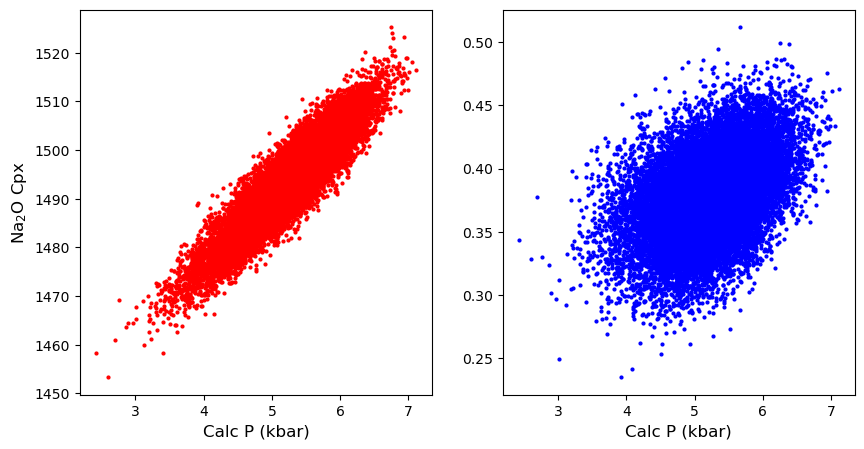

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['T_Wang21_eq2'], '.r' )
ax2.plot(Calc_PT['P_Wang21_eq1'], Calc_PT['Na2O_Cpx'], '.b' )
ax1.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')
ax1.set_ylabel('Na$_2$O Cpx')


## A more robust way to show this
- If you play around with duplicates = , you'll see that the more points you ask for, the more spread in pressure space. 
- It is more robust to contour results
- First, we show how to do this using hexbin (matplotlib)
- We underlie the published error on the barometer, at the average calculated composition.

<ErrorbarContainer object of 3 artists>

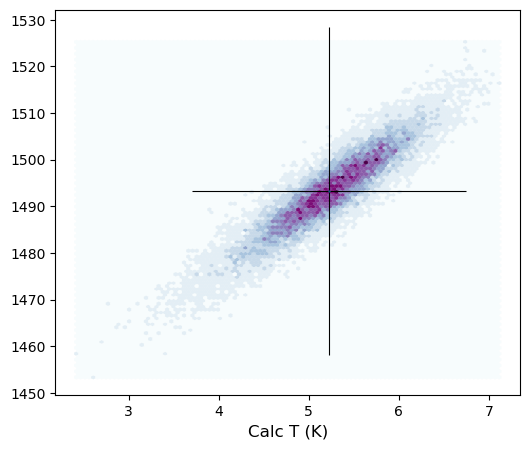

In [13]:
fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))

ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

## But this is still hard to visualize!
- We can add contours using pyrolite, so we can visualize where 67% of simulations lie, and where 95% of simulations lie
- You will have to play around a bit with the number of bins, and the extent parameter.
- We always plot PT first, then use that to work out the extent, which tells the code where to look for contours in. This only needs to be approximate. 
- This step can be slow, if you are using 4-8 Gb of Ram, you might want to reduce the number of duplicates when you make the samples. 
- Remember to cite Pyrolite if you use these contours!

Text(0, 0.5, 'Calc T (K)')

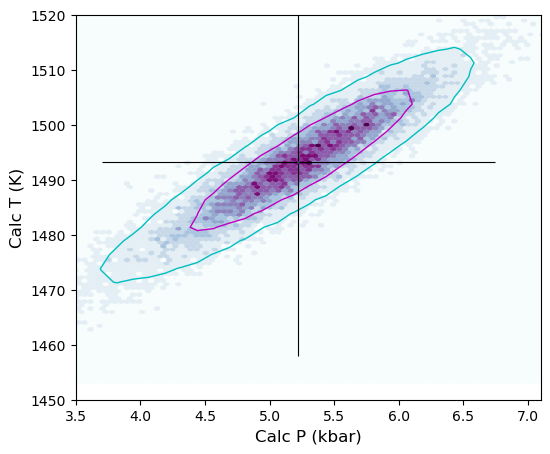

In [20]:
from pyrolite.plot import pyroplot

fig, (ax1)  = plt.subplots(1, 1, figsize=(6,5))

# This parameter helps pyrolite converge on the contour positions faster, 
# e.g. saying look for contours between 3.5 and 7 kbar
# and between 1470 and 1540 K. You'll need to change this for your particular system
extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=30, label_contours=False)
# Adjust axes limits
ax1.set_xlim([3.5, 7.1])
ax1.set_ylim([1450,  1520])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

## Lets work out what would happen if we doubled the analytical error on Na2O
- Be patient, this takes a bit of time, its 20,000 calculations! 

In [21]:
# First, lets duplicate the error dataframe
df_Cpx_Err_2Na=df_Cpx_Err.copy()
# Lets set Na2O error to 2* what it was
df_Cpx_Err_2Na['Na2O_Cpx_Err']=2*df_Cpx_Err['Na2O_Cpx_Err']
# And lets take sample 0 again
Cpx_1_Err_2Na=df_Cpx_Err_2Na.iloc[[0]].reset_index(drop=True)
# Lets simulate some new Cpxs. 
Calc_Cpx_dist_2Na=pt.add_noise_sample_1phase(phase_comp=Cpx_1, phase_err=Cpx_1_Err_2Na,
                                             phase_err_type="Perc", duplicates=20000, err_dist="normal")
# And lets calculate pressures
Calc_PT_2Na=pt.calculate_cpx_only_press_all_eqs(cpx_comps=Calc_Cpx_dist_2Na)

All negative numbers replaced with zeros. If you wish to keep these, set positive=False


## Lets plot these new errors vs. the old errors
- Again, the contours can take ~30s to appear (with 16 Gb of RAM)

c:\Users\penny\anaconda3\Lib\site-packages\pyrolite\util\plot\density.py:202: UserWarning: The following kwargs were not used by contour: 'width'
  cs = contour(


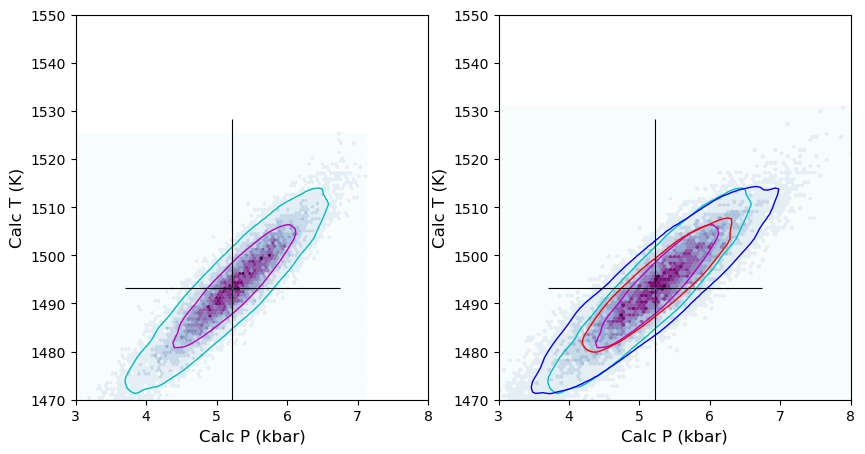

In [22]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)


extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')




extent2=(3.5, 7, 1470, 1540)
ax2.hexbin(Calc_PT_2Na['P_Wang21_eq1'],
           Calc_PT_2Na['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax2.set_xlabel('Calc P (kbar)')
ax2.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False, width=0.5)

Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax2, contours=[0.67, 0.95], colors=['r', 'blue'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False)

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax2.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)

ax1.set_xlim([3, 8])
ax1.set_ylim([1470,  1550])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')
ax2.yaxis.set_tick_params(which='both', labelbottom=True)

## Lets make a pretty figure for publication with just the stated errors for Wang and Putirka thermobarometers, but overlay an additional contour for bigger Na2O errors

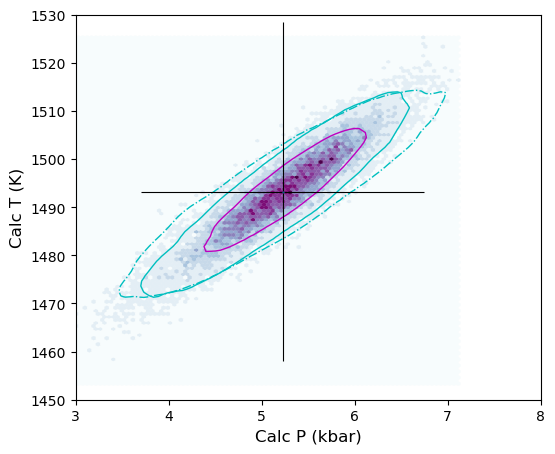

In [23]:
# Wang thermobarometers
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(3.5, 7, 1470, 1540)
ax1.hexbin(Calc_PT['P_Wang21_eq1'],
           Calc_PT['T_Wang21_eq2'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)


Calc_PT_2Na.loc[:, 
["P_Wang21_eq1", "T_Wang21_eq2"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Wang21_eq1']),
             np.mean(Calc_PT['T_Wang21_eq2']),
             xerr=1.52, yerr=35.2,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([3, 8])
ax1.set_ylim([1450,  1530])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error.png', dpi=200)

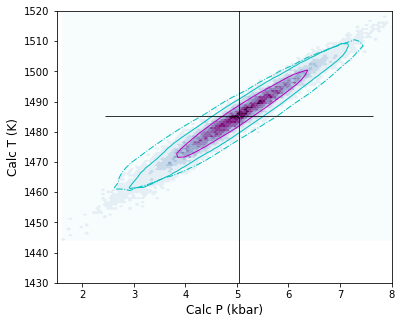

In [ ]:
# Putirka Cpx-only barometers
fig, (ax1)  = plt.subplots(1, figsize=(6,5), sharex=True, sharey=True)

## LHS, Wang et al. 2021
extent1=(1, 10, 1430, 1540)
ax1.hexbin(Calc_PT['P_Put_Teq32d_Peq32b'],
           Calc_PT['T_Put_Teq32d_Peq32b'],
            cmap=plt.cm.BuPu, 
            linewidths=0.2, bins=10)
ax1.set_xlabel('Calc P (kbar)')
ax1.set_xlabel('Calc T (K)')


Calc_PT.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.67, 0.95], colors=['m', 'c'],
                                                   extent=extent1, cmap="viridis", 
                                                   bins=70, label_contours=False)

extent2=(1, 10, 1430, 1540)

Calc_PT_2Na.loc[:, 
["P_Put_Teq32d_Peq32b", "T_Put_Teq32d_Peq32b"]].pyroplot.density(ax=ax1, contours=[0.95], colors=['c'],
                                                   extent=extent2, cmap="viridis", 
                                                   bins=70, label_contours=False,
                                                  linestyles=['-.'])

ax1.errorbar(np.mean(Calc_PT['P_Put_Teq32d_Peq32b']),
             np.mean(Calc_PT['T_Put_Teq32d_Peq32b']),
             xerr=2.6, yerr=58,
             fmt='.', ecolor='k', elinewidth=0.8, mfc='k', ms=1)


ax1.set_xlim([1.5, 8])
ax1.set_ylim([1430,  1520])

ax1.set_xlabel('Calc P (kbar)')
ax1.set_ylabel('Calc T (K)')

ax2.set_xlabel('Calc P (kbar)')
ax2.set_ylabel('Calc T (K)')

ax2.yaxis.set_tick_params(which='both', labelbottom=True)
fig.savefig('Cpx_only_Error_Put.png', dpi=200)

### Lets calculate the statistics for various noise simulations

In [24]:
Stats_P=pt.av_noise_samples_series(Calc_PT['P_Wang21_eq1'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,5.224174,5.243925,0.581436,0.574622,7.112735,2.418245


In [25]:
Stats_T=pt.av_noise_samples_series(Calc_PT['T_Wang21_eq2'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_T

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,1493.217726,1493.365316,8.596538,8.501955,1525.253951,1453.330584


In [26]:
Stats_T=pt.av_noise_samples_series(Calc_PT_2Na['T_Wang21_eq2'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_T

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,1493.243792,1493.461736,9.229113,9.180253,1530.644994,1453.990044


In [27]:
Stats_P=pt.av_noise_samples_series(Calc_PT_2Na['P_Wang21_eq1'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,5.22653,5.244425,0.721283,0.713538,8.01063,2.172848


In [28]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT_2Na['P_Put_Teq32d_Peq32b'], Calc_PT_2Na['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,5.00325,5.019843,0.952609,0.947076,8.946914,0.761413


In [29]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['P_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,5.035922,5.036038,0.844282,0.83978,8.088378,1.862193


In [30]:
Stats_P_Put=pt.av_noise_samples_series(Calc_PT['T_Put_Teq32d_Peq32b'], Calc_PT['Sample_ID_Cpx_Num'])
Stats_P_Put

,Sample,# averaged,Mean_calc,Median_calc,St_dev_calc,St_dev_calc_from_percentiles,Max_calc,Min_calc
0,0.0,20000,1485.247841,1485.337527,9.574996,9.55245,1520.120853,1443.237187
